# 프로젝트 : Segmentation map으로 도로 이미지 만들기  
목표 : Pix2Pix 실험해 보기 

프로젝트 설명 :   
이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었습니다. 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과입니다.  
<img src="./images/E20/e20-24.png"></img>
이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다. 데이터셋은 아래에서 다운로드할 수 있습니다.
1000개의 학습용 이미지 및 5개의 평가 이미지를 포함합니다.

[cityscapes](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/)   

이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없습니다.
아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같습니다.

프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고하시면서 이번 프로젝트를 수행해봅시다.
(아래 튜토리얼은 Pix2Pix 구조를 Functional API를 이용해 구현하기 때문에 이번에 진행한 Subclassing 방법을 이용한 모델 구현과 비교하면서 구현 방법에 대해서도 공부해 보시길 추천드립니다)

[Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)

프로젝트 수행
프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.
(어떠한 방법을 사용했는지 적어주세요.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

## Step1. 데이터 가져오기

In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [2]:
import os

PATH = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/'
data_path = os.path.join(PATH, 'train/')
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


데이터 확인 - 랜덤한 6장의 이미지

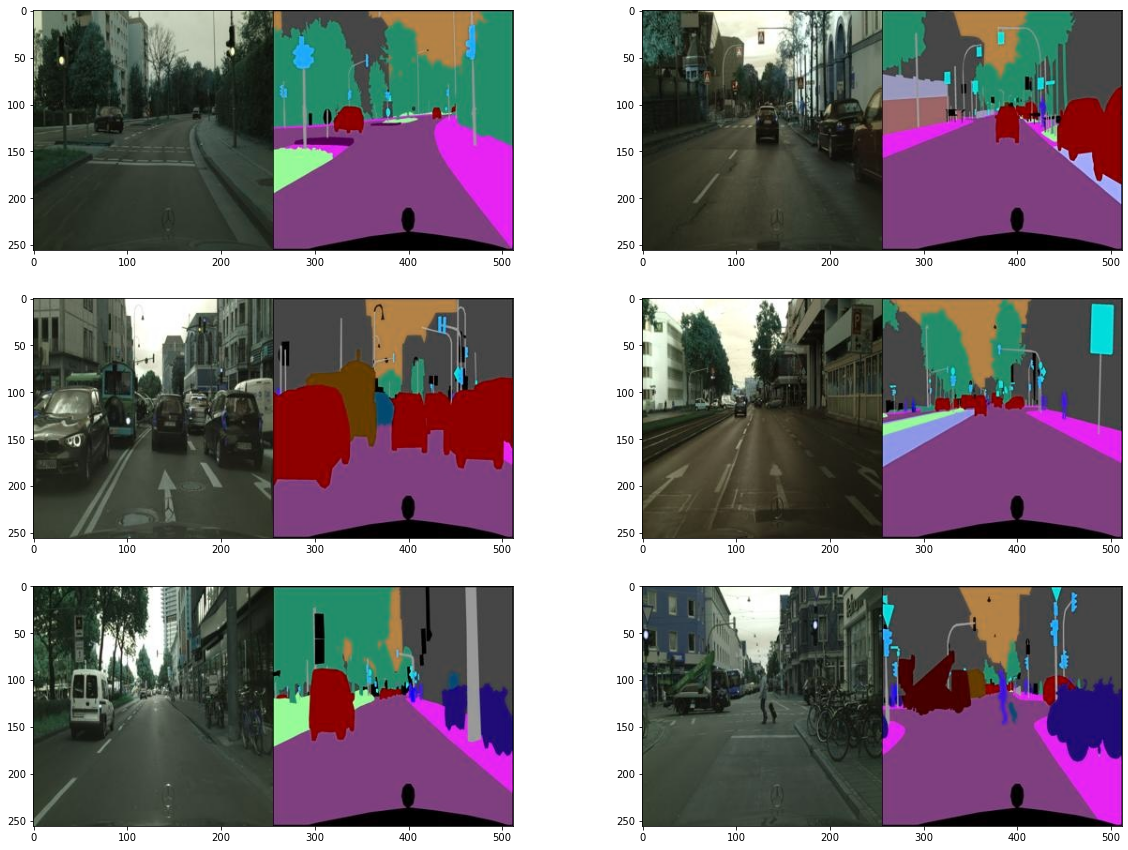

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [5]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

데이터 확인 - 실제이미지와 스케치한 이미지를 분리해서 확인

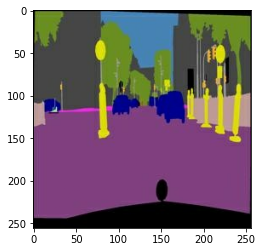

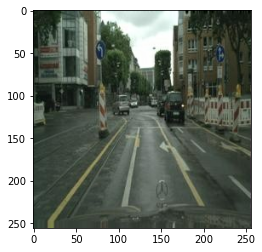

In [6]:
 f = data_path + os.listdir(data_path)[np.random.randint(800)]  
inp, re = load(f)
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

## Step2. 데이터 augmentation

무작위 지터링에서 이미지의 크기는 286 x 286로 조정되고 256 x 256로 무작위로 잘립니다.  
무작위 미러링에서는 이미지가 좌우로 무작위로 뒤집힙니다.  

In [55]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [8]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [9]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [10]:
@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
    # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

1. 더 큰 높이와 너비로 이미지의 크기를 조정합니다. (286x286 크기, 이미지 조정 방식은 NEAREST_NEIGHBOR 방식)
2. 대상 크기로 무작위 자릅니다.(256x256 크기)
3. 이미지를 가로로 무작위 뒤집습니다.

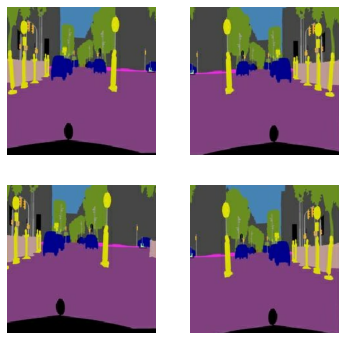

In [11]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [12]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image) # [-1, 1]

    return input_image, real_image

In [13]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image) # [-1, 1]

    return input_image, real_image

입력 파이프라인

In [14]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [15]:
train_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [16]:
test_dataset = tf.data.Dataset.list_files(PATH+'val/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [17]:
test_dataset

<BatchDataset shapes: ((None, 256, 256, None), (None, 256, 256, None)), types: (tf.float32, tf.float32)>

## Step3. 생성기 빌드하기

생성기 빌드하기
- 생성기 아키텍처는 수정된 U-Net입니다.
- 인코더의 각 블록은 (Conv -> Batchnorm -> Leaky ReLU)입니다.
- 디코더의 각 블록은 (Transposed Conv -> Batchnorm -> Dropout(처음 3개의 블록에 적용됨)-> ReLU)입니다.
- 인코더와 디코더 사이에는 스킵(skip) 연결이 있습니다(U-Net에서와 같이).

In [18]:
OUTPUT_CHANNELS = 3

In [19]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [20]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [21]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [22]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [23]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [24]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


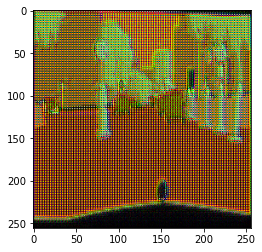

In [25]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

생성기 손실
- 이것은 생성된 이미지 및 1의 배열의 시그모이드 교차 엔트로피 손실입니다.
- 논문에는 생성 이미지와 대상 이미지 사이의 MAE(평균 절대 오차)인 L1 손실도 포함됩니다.
- 이를 통해 생성된 이미지가 대상 이미지와 구조적으로 유사해질 수 있습니다.
- 총 생성기 손실을 계산하는 공식 = gan_loss + LAMBDA * l1_loss. 여기서 LAMBDA = 100. 이 값은 논문 작성자가 결정했습니다.  

생성기의 훈련 절차는 다음과 같습니다.

In [26]:
LAMBDA = 100

In [27]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

## Step4. 판별자 빌드하기

판별자 빌드하기
- 판별자는 PatchGAN입니다.
- 판별자의 각 블록은 (Conv -> BatchNorm -> Leaky ReLU)입니다.
- 마지막 레이어 이후의 출력 형상은 (batch_size, 30, 30, 1)입니다.
- 출력의 각 30x30 패치는 입력 이미지의 70x70 부분을 분류합니다(이러한 아키텍처를 PatchGAN이라고 함).
- 판별자는 2개의 입력을 받습니다.
    + 진짜로 분류해야 하는 입력 이미지 및 대상 이미지
    + 가짜로 분류해야 하는 입력 이미지 및 생성된 이미지(생성기의 출력)
    + 코드에서 이 두 입력을 함께 연결합니다(tf.concat([inp, tar], axis=-1)).

In [33]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

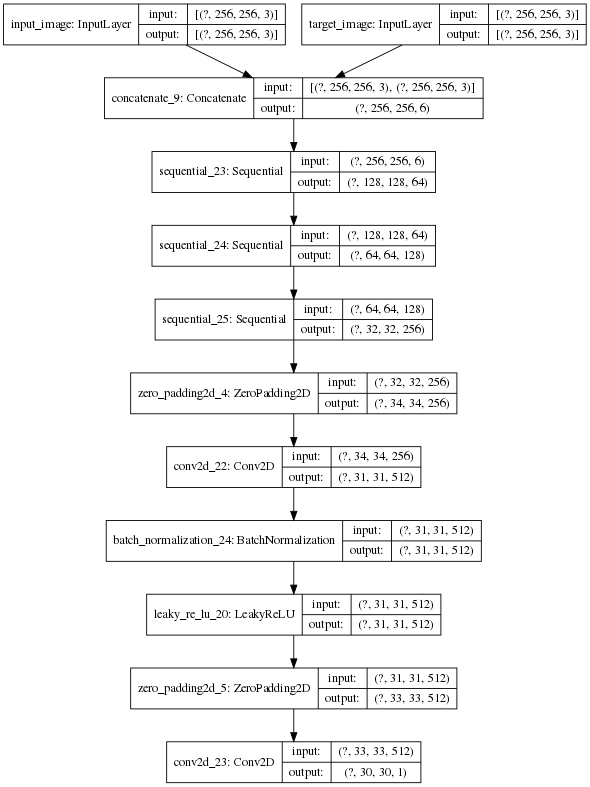

In [36]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

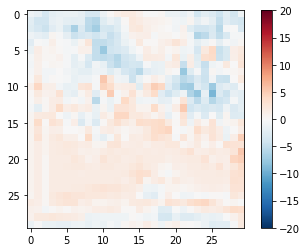

In [37]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

판별자 손실

- 판별자 손실 함수는 진짜 이미지, 생성된 이미지의 두 입력을 받습니다.
- real_loss는 진짜 이미지 및 1의 배열(진짜 이미지이기 때문)의 시그모이드 교차 엔트로피 손실입니다.
- generated_loss는 생성된 이미지 및 0의 배열(가짜 이미지이기 때문)의 시그모이드 교차 엔트로피 손실입니다.
- 그리고 total_loss는 real_loss와 generated_loss의 합계입니다.

In [38]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [39]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

<img src="./images/E20/e20-25.png"></img>

## Step5. 훈련하기

In [40]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [41]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

이미지 생성하기
훈련 중에 일부 이미지를 플롯하는 함수를 작성합니다.

- 테스트 데이터세트의 이미지를 생성기로 전달합니다.
- 그러면 생성기가 입력 이미지를 출력으로 변환합니다.
- 마지막 단계로 예상을 플롯합니다. 짜잔!  

참고: 여기서 training=True는 테스트 데이터세트에서 모델을 실행하는 동안 배치 통계를 얻으려고 하므로 의도적인 것입니다. training = False를 사용하면 훈련 데이터세트에서 학습한 누적 통계(이것을 원하지는 않음)를 얻게 됩니다.

In [42]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

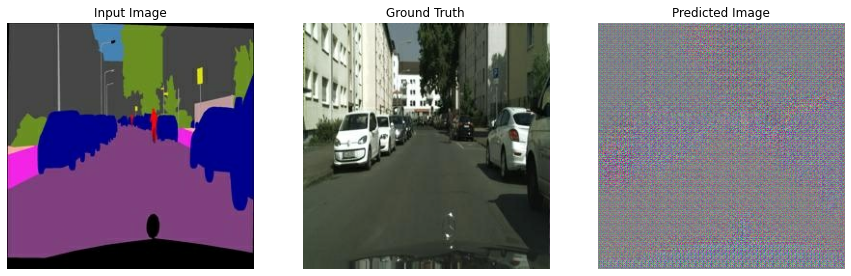

In [43]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

훈련하기
- 각 예에서 입력은 출력을 생성합니다.
- 판별자는 input_image 및 생성된 이미지를 첫 번째 입력으로 받습니다. 두 번째 입력은 input_image와 target_image입니다.
- 다음으로 생성기와 판별자 손실을 계산합니다.
- 그런 다음 생성기와 판별자 변수(입력) 모두에 대해 손실의 그래디언트를 계산하고 이를 옵티마이저에 적용합니다.
- 그런 다음 손실을 TensorBoard에 기록합니다.

In [44]:
EPOCHS = 150

In [45]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [46]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

실제 훈련 루프:

- epoch 수에 대해 반복합니다.
- 각 epoch에서 표시 내용을 지우고 generate_images를 실행하여 진행 상황을 표시합니다.
- 각 epoch마다 훈련 데이터세트에 대해 반복하여 각 예에 대해 '.'를 인쇄합니다.
- 20개 epoch마다 체크포인트를 저장합니다.

In [47]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
        print('.', end='')
        if (n+1) % 100 == 0:
            print()
        train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix)

훈련 루프는 TensorBoard에서 쉽게 볼 수 있는 로그를 저장하여 훈련 진행 상황을 모니터링  
`%load_ext tensorboard`  
`%tensorboard --logdir {log_dir}`  

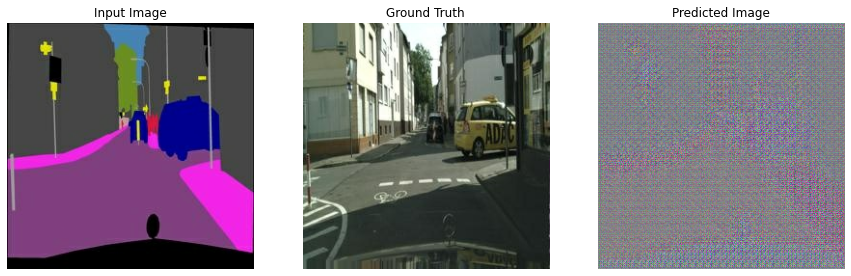

Epoch:  149
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...............................................................................

In [49]:
fit(train_dataset, EPOCHS, test_dataset)

In [51]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

In [52]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Step6. 결과 확인

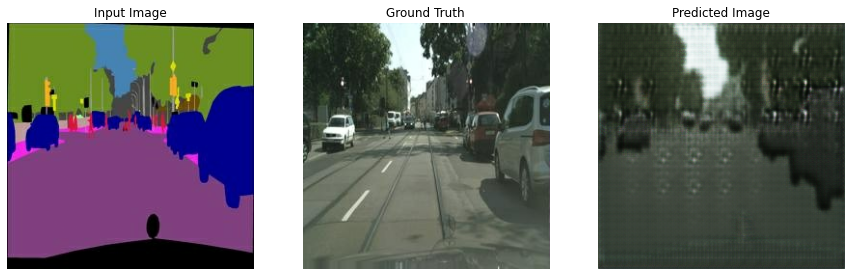

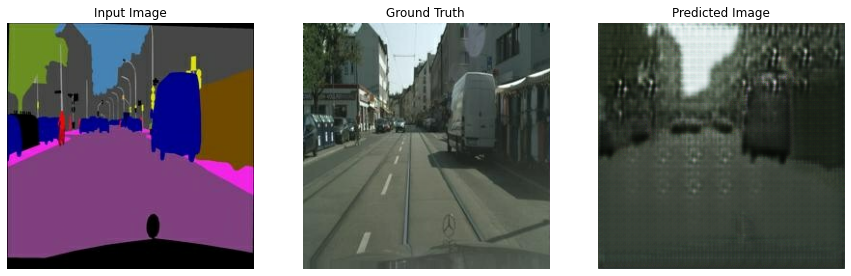

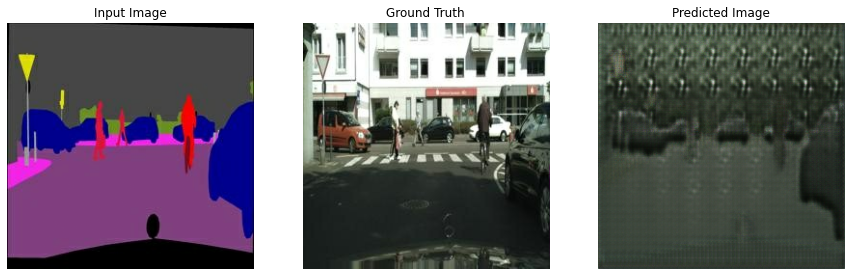

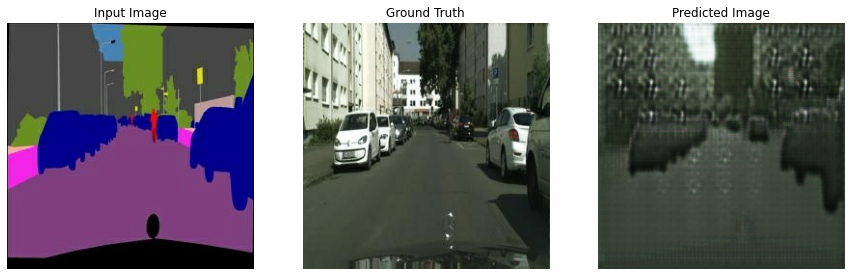

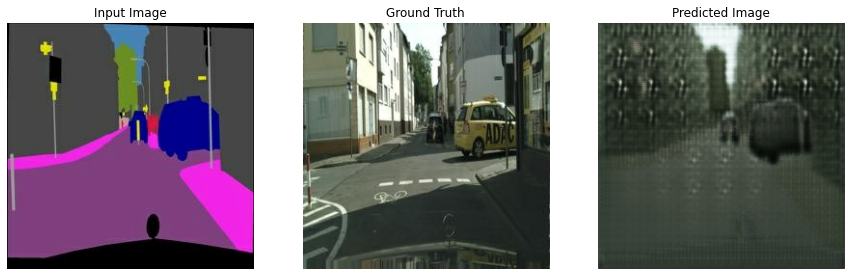

In [53]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)

## 느낀점

Pix2Pix를 배웠다.   
이전에 사용했던 일반적인 GAN이 전체 이미지에 대해 하나의 확률값을 출력하여 가짜/진짜를 판별하도록 학습하는 것이라면,    
Pix2Pix는 전체 영역을 다 보는 것이 아닌 일부 영역에 대해서만 가짜/진짜를 판별하여 하나의 확률값을 도출하는 것이다. 이미지를 입력하여 원하는 다른 형태의 이미지로 변환할 수 있는 GAN 모델이다.    
이번 노드에서는 TensorFlow 튜토리얼 코드를 활용했다.    
활용할 수 있는 코드는 많은데, 어느 것을 내 것으로 만드느냐가 중요한 거 같다.      